# Quantum Machine Learning Models with *qiboml*

Qiboml is an open-source and full-stack quantum machine learning package based on Qibo aiming at:

- providing automatically differentiable backends for any Qibo application;
- rendering Qibo circuits as differentiable layers of well-known machine learning frameworks such as Tensorflow and Pytorch;

## the general structure

<img src="https://qibo.science/qiboml/stable/_images/qiboml.png" width=800>

## Before starting
Make sure you have the most recent version of ``qiboml`` installed and a working version of ``torch`` and ``qibolab``.

In [1]:
# uncomment if you need to install

#!pip install git+https://github.com/qiboteam/qiboml#
#!pip install torch

!pip install qibolab[emulator]

zsh:1: no matches found: qibolab[emulator]


# Data regression through a Reuploading model

In this tutorial we show how to setup and train a quantum machine learning model implementing a Data Reuploading strategy.
We will make use of our interface to structure a quantum circuit which is composed of an alternating execution of trainable and encoding layers.

In fact, the main idea behind data reuploading strategies is that data are encoded more than once into our quantum machine learning model. This approach usually leads to a quantum circuit which is approximating a target in a way which is equivalent to a Fourier approximation. In particular, the number of times the data are uploaded is proportional to the number of frequencies populating the Fourier spectrum and the parametrized part of the circuit is responsible of the tuning of the coefficients of this same Fourier series. For more details, a good reference is [Schuld M., Sweke R., Meyer J. - 2021](https://arxiv.org/abs/2008.08605).

<img src="./figures/reuploading.svg" width="600" height="200" alt="My Image">

### Some imports

In [2]:
# Let's do the imports first

import torch
torch.set_default_dtype(torch.float64)
import numpy as np
import matplotlib.pyplot as plt
import os

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, construct_backend, set_backend
from qibo.hamiltonians import Z
from qibo.transpiler import Passes, NativeGates, Unroller

from qibolab import create_platform

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.ansatze import HardwareEfficient
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR

2025-07-18 15:10:48.514896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752844248.527516   72912 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752844248.531416   72912 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752844248.541741   72912 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752844248.541755   72912 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752844248.541757   72912 computation_placer.cc:177] computation placer alr

### The target function to be fitted

To the purpose of this introductory example, we are going to fit a one-dimensional function.

In [3]:
# Prepare the training dataset 
def f(x):
    return 1 * torch.sin(x)  ** 2 - 0.3 * torch.cos(x) 

num_samples = 30
x_train = torch.linspace(0, 2 * np.pi, num_samples, dtype=torch.float64).unsqueeze(1)
y_train = f(x_train)

# Normalizing it to be between -1 and 1 (because we are going to use a Z observable in our decoding)
y_train = 2 * ( (y_train - min(y_train)) / (max(y_train) - min(y_train)) - 0.5 )

In [4]:
# A plotting function which will be useful now and later
def plot_target(x, target, predictions=None):
    """Plot target function and, optionally, the predictions of our model."""
    plt.figure(figsize=(4, 4 * 6 / 8), dpi=120)
    plt.plot(
        x_train.detach().cpu().numpy(), 
        y_train.detach().cpu().numpy(),
        marker=".",
        markersize=10,
        color="blue", 
        label="Targets",
        alpha=0.7
    )
    if predictions is not None:
        plt.plot(
            x_train.detach().cpu().numpy(), 
            y_pred.detach().cpu().numpy(), 
            marker=".",
            markersize=10,
            color="red", 
            label="Predictions",
            alpha=0.7
        )
    plt.xlabel(r"$x$")
    plt.ylabel(r"$f(x)$")
    plt.legend()
    plt.show()

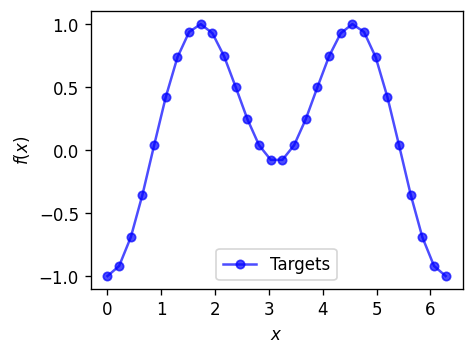

In [5]:
# Plotting
plot_target(x=x_train, target=y_train)

### The model's building blocks

We now need to construct our QML model, composed by three main building blocks: encoding layers, trainable layers and decoding.
Since we are going to fit a one dimensional function we will need just one qubit.

### Encoder
Let's start from the encoding layer. The ``PhaseEncoding`` object allows us to encode data into a single qubit rotation around the $x$ axis.

In [6]:
# Setting the number of qubits
nqubits = 1

# Encoding layer
encoding_circ = PhaseEncoding(
    nqubits=nqubits, 
    encoding_gate=gates.RX
)
encoding_circ

PhaseEncoding(nqubits=1, qubits=(0,), density_matrix=False, _circuit=<qibo.models.circuit.Circuit object at 0x7f36e03aeb00>, encoding_gate=<class 'qibo.gates.gates.RX'>)

### Trainable layer
Then, we need to define a trainable circuit layer. For instance, we can use the ``HardwareEfficient`` ansatz for convenience, but any parametric quantum circuit would do.

In [7]:
# Trainable layer
trainable_circuit = HardwareEfficient(nqubits=nqubits)
trainable_circuit.draw()

0: ─RY─RZ─


### Composing the Reuploading pattern

Let's combine now together the encoding layers and the trainable layers to build the reuploading model. 
- **Note:** make sure that the instances of the trainable layers are different objects, or Pytorch will train all the layers as they are references to the same object (with the same parameters).

In [8]:
# We set a number of layers
nlayers = 2

# We initialise an empty circuit structure
circuit_structure = []
# We populate it with alternation of encoding (always the same) and trainable layers (always a new instance)
for _ in range(nlayers):
    circuit_structure.extend([encoding_circ, trainable_circuit.copy(True)])

### Decoder
Last but not least, a decoding strategy needs to be defined to extract the classical information from the final quantum state. A quite common choice is to compute the expectation value of an observable. In particular, the ``Expectation`` decoder object computes by default the expectation value of a non interacting Z hamiltonian. 

Before creating the decoder, remember to set the backend you wish to run with, for instance by using the ``torch`` backend with the ``torch`` interface we ensure that pytorch's native autodifferentiation is used. 


In [9]:
# set the execution backend
set_backend("qiboml", platform="pytorch")

# Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits,
    observable=Z(nqubits), # this is the default choice anyway
)

[Qibo 0.2.20|INFO|2025-07-18 15:10:50]: Using qiboml (pytorch) backend on cuda:0


### The complete Quantum Model

Finally, we can assemble the whole quantum model using ``qiboml``'s pytorch interface.

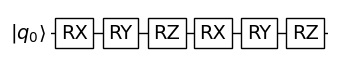

In [10]:
# The whole model, this is a torch.nn.Module object
model = QuantumModel(
    circuit_structure=circuit_structure,
    decoding=decoding_circ,
)

# Let's draw it
fig = model.draw()

### Use Pytorch to train it!

Now, we can setup a standard Pytorch training loop to find an optimal quantum circuit for fitting our target function. 

We start by selecting a desired optimizer and cost function:

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

then, we move everything to the correct device (GPU if available, CPU otherwise):

In [12]:
dev = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(dev)
x_train = x_train.to(dev)
y_train = y_train.to(dev)

And we then perform a classical training loop.

In [13]:
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    # Use torch.stack to get a tensor of shape (100, 1, 1)
    y_pred = torch.stack([model(x) for x in x_train])
    # Remove the extra singleton dimension so that y_pred has shape (100, 1)
    y_pred = y_pred.squeeze(-1)
    
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

Epoch 0: Loss = 0.16730625812898395
Epoch 10: Loss = 0.03470810374033367
Epoch 20: Loss = 0.015215399049728425
Epoch 30: Loss = 0.006473859418667709
Epoch 40: Loss = 0.005540042961188239
Epoch 50: Loss = 0.00509900736712839
Epoch 60: Loss = 0.004742847760016528
Epoch 70: Loss = 0.004603921791602154
Epoch 80: Loss = 0.004566346307158054
Epoch 90: Loss = 0.004561392446958933


### A final look to our results

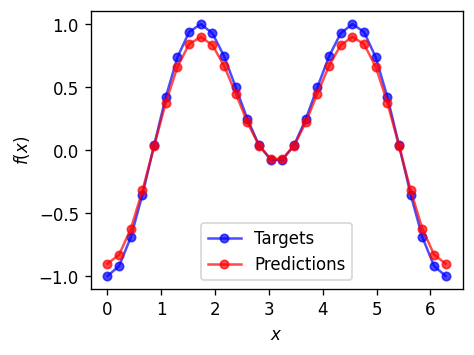

In [14]:
plot_target(x=x_train, target=y_train, predictions=y_pred)

We fitted it 🥳

### A more realistic case
In the previous example, we used the ``pytorch`` backend to simulate computation, however, as you've seen yesterday, there are more realistic ways to simulate quantum computation on a superconducting device, e.g. using an **Emulator**.
Let's change the global backend to the emulator runcard that we prepared already.

In [15]:
os.environ["QIBOLAB_PLATFORMS"] = "../"
platform = create_platform("emulator")
set_backend("qibolab", platform=platform)

[Qibo 0.2.20|INFO|2025-07-18 15:10:59]: Loading platform emulator
[Qibo 0.2.20|INFO|2025-07-18 15:10:59]: Using qibolab (emulator) backend on /CPU:0


Since we changed the backend, it is a good idea to define a new decoder from scratch. We will always use the ``Expectation`` decoder, but this time, since we are runnning in a more realistic scenario, we need to specify some additional settings:
- **nshots**: the number of samples we generate
- **transpiler**: the transpilation pipeline used to translate the high-level circuit into the native operations supported by the device

In [16]:
nshots = 1000
transpiler = Passes(
    connectivity=[], # this is the topology of the chip, since we are using just a
                     # single qubit, there's no connectivity to respect
    passes=[Unroller(NativeGates.default())]
)

The original circuit was:

In [17]:
trainable_circuit.draw()

0: ─RY─RZ─


after transpilation the non-native ``RY`` gate is converted into a sequence of native ``GPI2``, ``Z`` and ``RZ`` gates.

In [18]:
transpiler(trainable_circuit)[0].draw()

0: ─GPI2─RZ─GPI2─Z─RZ─


Therefore, we can now build a new decoder to be used with the emulator:

In [19]:
# New Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits,
    observable=Z(nqubits),
    nshots=nshots,
    transpiler=transpiler,
)

Now, let's assemble the quantum model as before.

In [20]:
model = QuantumModel(
    circuit_structure=circuit_structure,
    decoding=decoding_circ,
).to(dev)

 However, the emulator is extremly taxing (and thus slow) unfortunately, since it involves the computation of the evolution of the system's hamiltonian through a master equation. Therefore, for this short tutorial we cannot afford to train a new model from scratch with the emulator. What we can do though, is verify how running with the emulator affects the predictions of our trained model at inference time:

[Qibo 0.2.20|INFO|2025-07-18 15:10:59]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:01]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:02]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:04]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:05]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:06]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:08]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:10]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:11]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:12]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:14]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:15]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:17]: Minimal execution time: 0.000321
[Qibo 0.2.20|INFO|2025-07-18 15:11:18]: Minimal exe

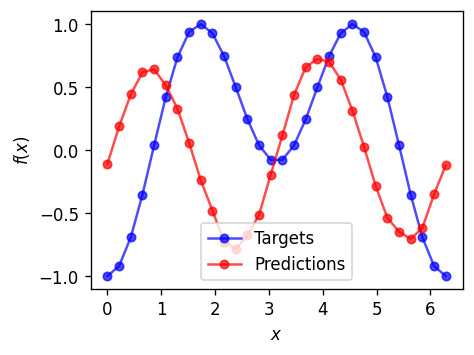

In [21]:
with torch.no_grad():
    y_pred = torch.stack([model(x) for x in x_train])
    y_pred = y_pred.squeeze(-1)
plot_target(x=x_train, target=y_train, predictions=y_pred)

In [30]:
decoding_circ = Expectation(
    nqubits=nqubits,
    observable=Z(nqubits),
    nshots=nshots,
    transpiler=transpiler,
    mitigation_config= {
        "threshold": 0.1,
        "min_iterations": 500,
        "method": "CDR",
        "method_kwargs": {"n_training_samples": 100, "nshots": max(nshots, 5000)},
    }
)
from qiboml.interfaces import utils
utils._uniform_circuit_structure(circuit_structure)
print(circuit_structure)
print(utils.get_params_from_circuit_structure(circuit_structure))
from qibo import get_backend
b = get_backend()
print(b)
print(b.to_numpy(utils.get_params_from_circuit_structure(circuit_structure)))
model = QuantumModel(
    circuit_structure=circuit_structure,
    decoding=decoding_circ,
)
with torch.no_grad():
    y_pred = torch.stack([model(x.cpu()) for x in x_train])
    y_pred = y_pred.squeeze(-1)

[PhaseEncoding(nqubits=1, qubits=(0,), density_matrix=False, _circuit=<qibo.models.circuit.Circuit object at 0x7f36e03aeb00>, encoding_gate=<class 'qibo.gates.gates.RX'>), <qibo.models.circuit.Circuit object at 0x7f36e03c0eb0>, PhaseEncoding(nqubits=1, qubits=(0,), density_matrix=False, _circuit=<qibo.models.circuit.Circuit object at 0x7f36e03aeb00>, encoding_gate=<class 'qibo.gates.gates.RX'>), <qibo.models.circuit.Circuit object at 0x7f36e022c220>]
[array(2.17446229), array(3.14180349), array(2.62026192), array(3.09892182)]
qibolab (emulator)
[array(2.17446229), array(3.14180349), array(2.62026192), array(3.09892182)]


TypeError: len() of unsized object